In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import math
import pickle
import random
from collections import Counter

from hurry.filesize import size

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

In [2]:
for font in mpl.font_manager.findSystemFonts('.'):
    mpl.font_manager.fontManager.addfont(font)
    print(font)
    
mpl.rcParams['font.family'] = 'Gulliver'
sns.set(font="Gulliver", style='ticks')

/data/sgh_candida_auris/submission/analyses/scripts/Gulliver Regular.otf


In [3]:
with open('lancet_color_palettes.txt', 'r') as handle:
    lines = [l.strip() for l in handle.readlines()]

lancet_cmap = ListedColormap([mpl.colors.to_rgba(c, alpha=1) for c in lines])
lancet_light_cmap = ListedColormap([mpl.colors.to_rgba(c, alpha=0.6) for c in lines])

# Read input files

In [22]:
# SNP distance matrix
with open("snp_dist_df.pickle", "rb") as infile:
    snp_dist_df = pickle.load(infile)

# Sample info
run_date_info_df = pd.read_excel('candida_auris_sra_list_date.xlsx', index_col='Run')

# QC stats
qc_df = pd.read_excel('qc_for_external_data.xlsx', index_col=0)

In [23]:
sample_passed_qc_list = sorted(list(qc_df[qc_df['qc']==True].index))
n_samples = len(sample_passed_qc_list)
n_samples

3654

In [26]:
run_date_info_df[run_date_info_df.index.isin(sample_passed_qc_list)].groupby('Clade').size()

Clade
I      450
II      21
III    451
IV     205
V        5
VI       4
dtype: int64

# Prepare data for the models

## Select SNP distance for samples that passed QC

In [27]:
snp_dist_df = snp_dist_df.loc[sample_passed_qc_list, sample_passed_qc_list]

## Create a new dataframe for genome pairs

In [43]:
pair_df = snp_dist_df.stack().reset_index()
pair_df.columns = ['A', 'B', 'SNP distance']

# select only one edge (keep self edge)
pair_df = pair_df[pair_df['A'] <= pair_df['B']]

print(snp_dist_df.shape, len(set(pair_df['A']).union(set(pair_df['B']))))
pair_df

(3654, 3654) 3654


,A,B,SNP distance
0,DRR129820,DRR129820,0
1,DRR129820,DRR129821,568
2,DRR129820,DRR129822,546
3,DRR129820,DRR129823,554
4,DRR129820,DRR129824,621
...,...,...,...
13344406,SRR9645764,SRR9993948,131406
13344407,SRR9645764,SRR9993949,50594
13348060,SRR9993948,SRR9993948,0
13348061,SRR9993948,SRR9993949,121412


Adding clade information

In [44]:
pair_df = pd.merge(pair_df, qc_df[['Clade', 'SRA release quater']], 
                   left_on='A', right_index=True, how='left')
pair_df.columns = pair_df.columns[:-2].to_list() + ['A (Clade)', 'A (SRA)']
pair_df = pd.merge(pair_df, qc_df[['Clade', 'SRA release quater']], 
                   left_on='B', right_index=True, how='left')
pair_df.columns = pair_df.columns[:-2].to_list() + ['B (Clade)', 'B (SRA)']

known_clade_pair_df = pair_df.dropna(subset=['A (Clade)', 'B (Clade)']).reset_index(drop=True)
known_clade_pair_df.loc[:, 'Same clade'] = known_clade_pair_df['A (Clade)'] == known_clade_pair_df['B (Clade)']

print(len(set(pair_df['A']).union(set(pair_df['B']))), len(set(known_clade_pair_df['A']).union(set(known_clade_pair_df['B']))))
known_clade_pair_df

3654 1136


,A,B,SNP distance,A (Clade),A (SRA),B (Clade),B (SRA),Same clade
0,DRR129820,DRR129820,0,II,2019-3,II,2019-3,True
1,DRR129820,DRR129821,568,II,2019-3,II,2019-3,True
2,DRR129820,DRR129822,546,II,2019-3,II,2019-3,True
3,DRR129820,DRR129823,554,II,2019-3,II,2019-3,True
4,DRR129820,DRR129824,621,II,2019-3,II,2019-3,True
...,...,...,...,...,...,...,...,...
645811,SRR9645762,SRR9993948,131410,II,2019-4,IV,2019-3,False
645812,SRR9645762,SRR9993949,50578,II,2019-4,I,2019-3,False
645813,SRR9993948,SRR9993948,0,IV,2019-3,IV,2019-3,True
645814,SRR9993948,SRR9993949,121412,IV,2019-3,I,2019-3,False


Plot distances of pairs that clade information was previousely reported

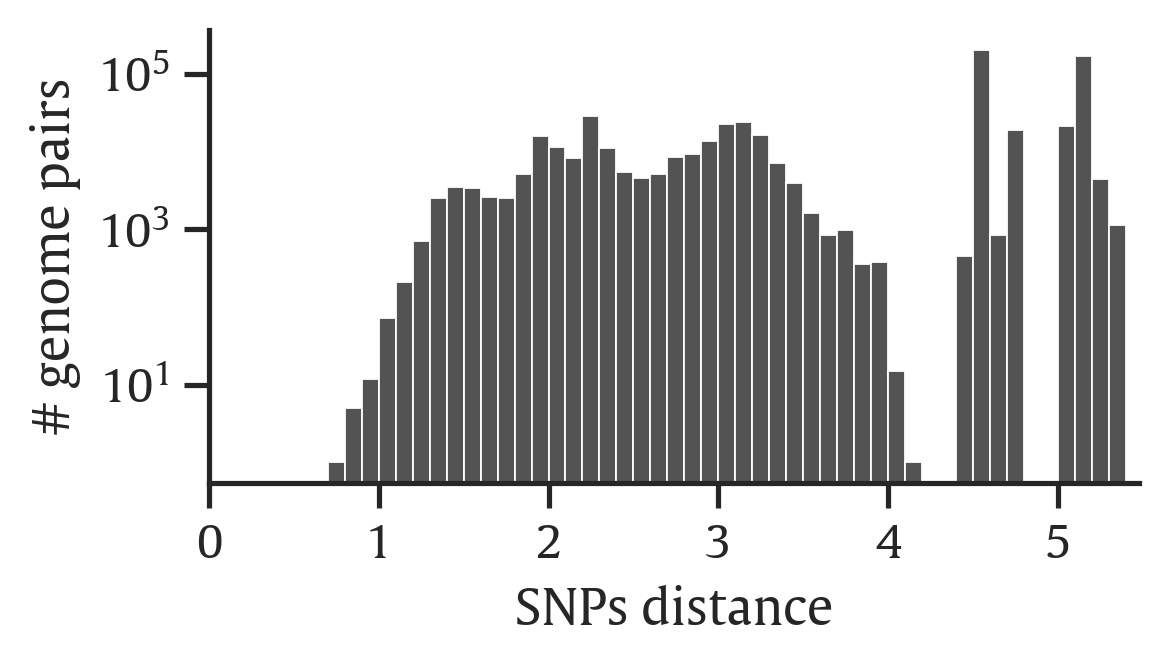

In [45]:
sns.set(font="Gulliver", style='ticks')
fig, ax = plt.subplots(figsize=(4,2))
ax = sns.histplot(np.log10(known_clade_pair_df[known_clade_pair_df['A']!=known_clade_pair_df['B']]['SNP distance']),
                  color=lancet_cmap.colors[-1], edgecolor='white', binwidth=0.1
                 )
ax.set_xlim((np.log10(1), np.log10(300000)))
ax.set_yscale('log')
ax.set_ylabel('# genome pairs')
ax.set_xlabel('SNPs distance (log)')
sns.despine()

Print the maximum SNP distance observed within clade

In [46]:
known_clade_pair_df[known_clade_pair_df['Same clade']==True].sort_values('SNP distance', ascending=False).head(5)

,A,B,SNP distance,A (Clade),A (SRA),B (Clade),B (SRA),Same clade
167083,SRR10461203,SRR9993948,12703,IV,2020-1,IV,2019-3,True
166421,SRR10461203,SRR14802929,12400,IV,2020-1,IV,2021-3,True
141646,SRR10461178,SRR14802929,12112,IV,2020-1,IV,2021-3,True
142308,SRR10461178,SRR9993948,12103,IV,2020-1,IV,2019-3,True
166743,SRR10461203,SRR7909226,11989,IV,2020-1,IV,2018-3,True


Print the minimum SNP distance observed between clades

In [47]:
known_clade_pair_df[known_clade_pair_df['Same clade']==False].sort_values('SNP distance', ascending=True).head(5)

,A,B,SNP distance,A (Clade),A (SRA),B (Clade),B (SRA),Same clade
352146,SRR14252435,SRR14802917,29141,I,2021-2,III,2021-3,False
417789,SRR14802917,SRR3883437,29144,III,2021-3,I,2016-3,False
417822,SRR14802917,SRR3883473,29149,III,2021-3,I,2016-3,False
328731,SRR13362216,SRR14802917,29154,I,2021-1,III,2021-3,False
238790,SRR11485325,SRR14802917,29160,I,2020-2,III,2021-3,False


Plot SNP distance statistics (within clade)

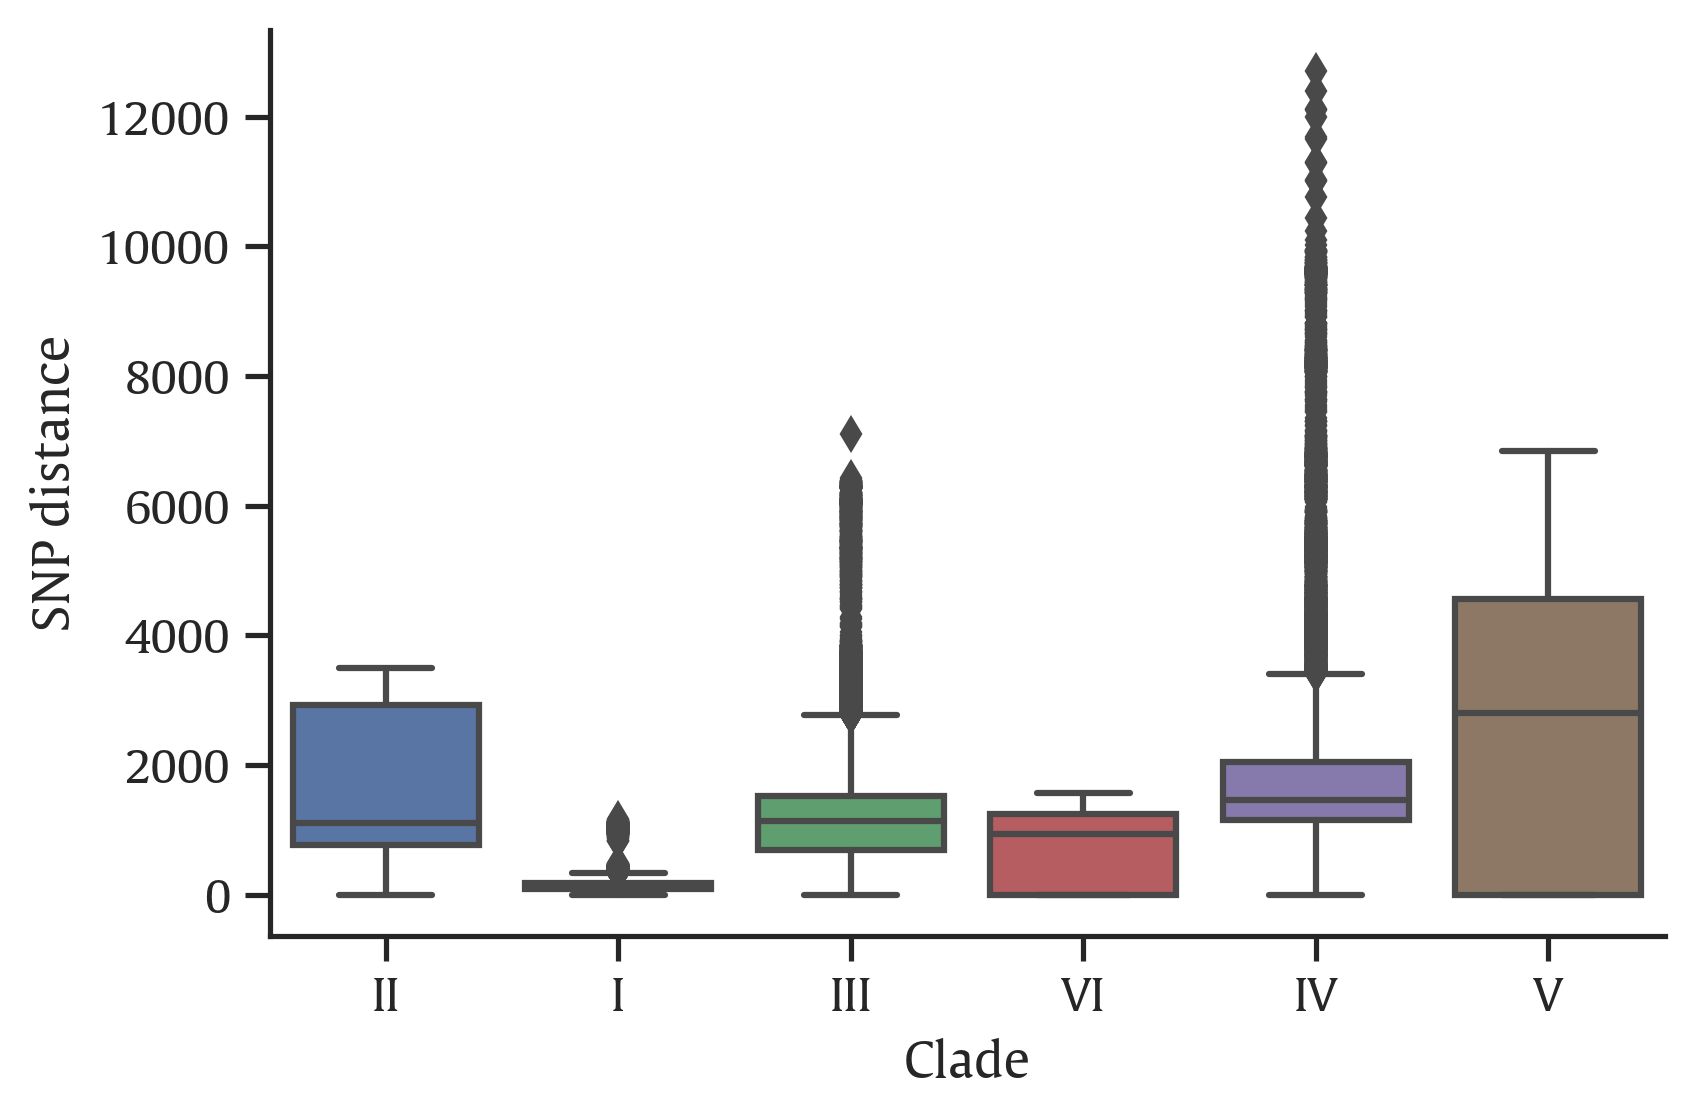

In [50]:
sns.set(font="Gulliver", style='ticks')
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.boxplot(data=known_clade_pair_df[known_clade_pair_df['Same clade']==True], x='A (Clade)', y='SNP distance')
ax.set_xlabel('Clade')
sns.despine()

Plot SNP distance statistics (between vs within clade)

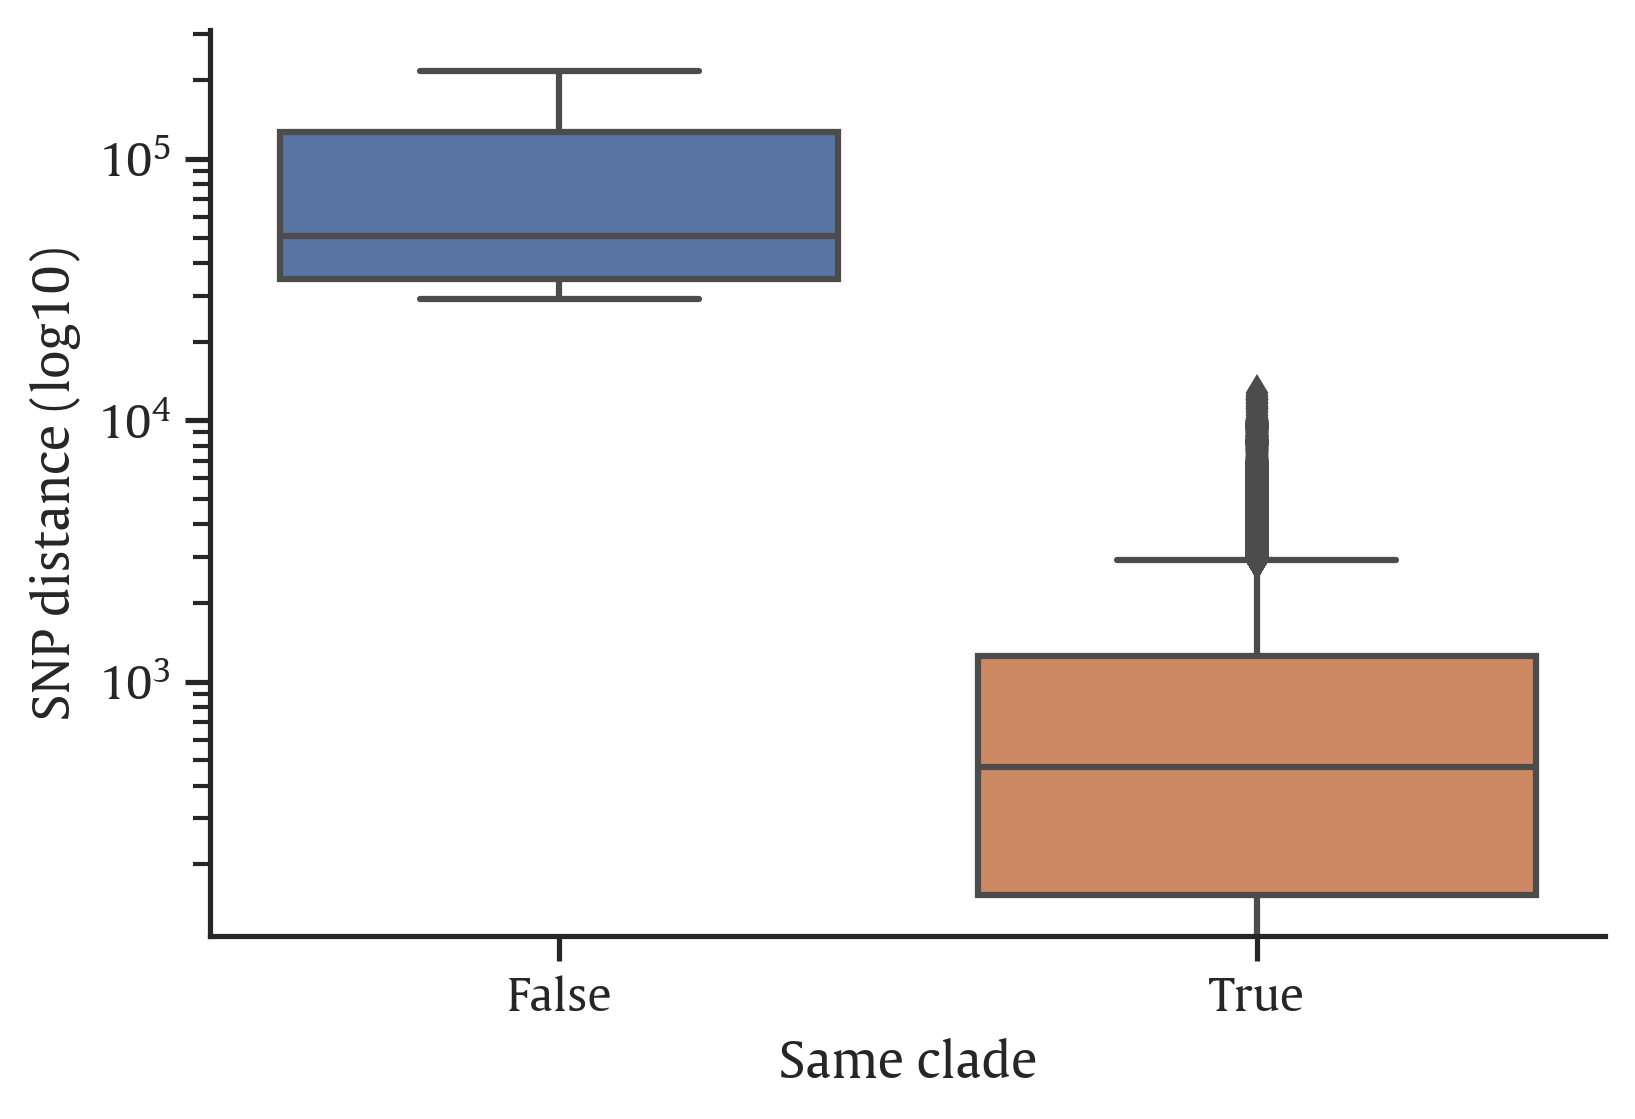

In [51]:
sns.set(font="Gulliver", style='ticks')
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.boxplot(data=known_clade_pair_df, x='Same clade', y='SNP distance')
ax.set_ylabel('SNP distance (log10)')
ax.set_yscale('log')
sns.despine()

# Create a graph

In [52]:
n_nodes = len(set(pair_df['A']).union(set(pair_df['B'])))
n_nodes

3654

In [53]:
import networkx as nx

G = nx.from_pandas_edgelist(pair_df, "A", "B", "SNP distance")
print(f"# nodes: {G.number_of_nodes()}")
print(f"# connected components: {len([c for c in nx.connected_components(G)])}")

# nodes: 3654
# connected components: 1


Adding clade information and selece time points

In [64]:
sample_id_clade_dict = dict(zip(qc_df.index, qc_df['Clade']))
nx.set_node_attributes(G, sample_id_clade_dict, name="clade")

In [65]:
quarter_list = []
for y in range(2019, 2023+1):
    for q in range(1, 4+1):
        quarter_list += [f"{y}-{q}"]
quarter_list = quarter_list[:-1]

print(len(quarter_list))
quarter_list

19


['2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2020-1',
 '2020-2',
 '2020-3',
 '2020-4',
 '2021-1',
 '2021-2',
 '2021-3',
 '2021-4',
 '2022-1',
 '2022-2',
 '2022-3',
 '2022-4',
 '2023-1',
 '2023-2',
 '2023-3']

Create a utility function for calculating purity score

In [66]:
def cal_purity(count_dict):
    count_list = []
    for c_name, c_count in count_dict.items():
        # ignore nan
        if not pd.isnull(c_name):
            count_list += [c_count]

    if len(count_list) == 0:
        return np.nan, np.nan, np.nan
    else:
        sorted_count_list = sorted(count_list)
        top = sorted_count_list[-1]
        others = np.sum(sorted_count_list[:-1])
        purity = (2*top/(top+others))-1

        return top, others, purity
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Bayesian model inferrence

This step takes about 30-60 minutes.

Note: Increasing number of tune might get rid of the divergence warning message. However, the traces results and decision boundaries learned across time points looks stable.

In [71]:
import pymc3 as pm
import arviz as az

np.random.seed(1)

import logging
logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)
logger.propagate = False

In [72]:
results = []

sample_size = 25000 # Subsampling edges to speed up
# Future: batch the training data instead of sampling

for q in quarter_list:
    q_pair_df = pair_df[(pair_df['A (SRA)'] <= q) & (pair_df['B (SRA)'] <= q)]
    print(f"\n######\n{q}\n######")
    
    q_nodes = list(set(q_pair_df['A']).union(set(q_pair_df['B'])))
    q_graph = G.subgraph(q_nodes)
    
    # Create trining set based on known clade info
    train_df = q_pair_df.dropna(subset=['A (Clade)', 'B (Clade)']).reset_index(drop=True) \
                            [['A (Clade)', 'B (Clade)', 'SNP distance']]
    if train_df.shape[0] > sample_size:
        train_df = train_df.sample(sample_size)
    
    train_df.loc[:, 'Same clade'] = train_df['A (Clade)'] == train_df['B (Clade)']
    train_df.columns = ['A', 'B', 'dist', 'target']

    # Define and set bayesian models
    y_simple = (train_df['target'])
    x = train_df['dist'].values

    with pm.Model() as model_simple:
        α = pm.Normal('α', mu=0, sd=10)
        β = pm.Normal('β', mu=0, sd=10)

        μ = α + pm.math.dot(x, β)
        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -α/β)

        y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

        trace_simple = pm.sample(1000, cores=4, tune=1000, progressbar=False)
        
        t_min, t_max = az.hdi(trace_simple['bd'], hdi_prob=0.95)
        t_mode = az.hdi(trace_simple['bd'], hdi_prob=0.05).mean()
    
    print(f"{q}: {t_mode} ({t_min}, {t_max})")
    
    # Extract the traces
    alpha_mode = az.hdi(trace_simple['α'], hdi_prob=0.05).mean()
    beta_mode = az.hdi(trace_simple['β'], hdi_prob=0.05).mean()
    bd_mode = az.hdi(trace_simple['bd'], hdi_prob=0.05).mean()
    bd_hdi_min, bd_hdi_max = az.hdi(trace_simple['bd'], hdi_prob=0.95)
    q_learn_graph = q_graph.edge_subgraph([(a, b) for a, b, attr in q_graph.edges(data=True) \
                                           if attr['SNP distance'] <= bd_hdi_max])
    
    # Count number of connected components
    n_connected_components = nx.number_connected_components(q_learn_graph)
    print(f"# nodes: {q_learn_graph.number_of_nodes()}")
    print(f"# connected components: {n_connected_components}")
    
    # Calculate purity scores
    known_clade_size_list = []
    purity_list = []
    for i, c in enumerate(nx.connected_components(q_learn_graph)):
        c_graph = q_learn_graph.subgraph(c)
        clades = [c_dict['clade'] for (c_id, c_dict) in c_graph.nodes(data=True)]
        clade_count_dict = Counter(clades)
        top, others, purity = cal_purity(clade_count_dict)
        print(f"c{i+1}: {Counter(clades)} [Top={top} Other={others} Purity={purity}]")

        known_clade_size_list += [top+others]
        purity_list += [purity]
        
    weight = np.array(known_clade_size_list)/np.nansum(known_clade_size_list)
    weighted_purity = np.nansum(weight * np.array(purity_list))
    print(f"Weighted purity = {weighted_purity}")
        
    # Save result for each time point
    results += [[q, q_learn_graph.number_of_nodes(),
                 nx.number_connected_components(q_learn_graph),
                 bd_mode, bd_hdi_min, bd_hdi_max,
                 weighted_purity
                ]]


######
2019-1
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 370 divergences after tuning. Increase `target_accept` or reparameterize.
There were 360 divergences after tuning. Increase `target_accept` or reparameterize.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
There were 352 divergences after tuning. Increase `target_accept` or reparameterize.


2019-1: 8484.22071697011 (6042.157430505419, 19495.01574596299)
# nodes: 554
# connected components: 4
c1: Counter({'I': 306, nan: 33}) [Top=306 Other=0.0 Purity=1.0]
c2: Counter({'III': 93}) [Top=93 Other=0.0 Purity=1.0]
c3: Counter({'IV': 116}) [Top=116 Other=0.0 Purity=1.0]
c4: Counter({'II': 6}) [Top=6 Other=0.0 Purity=1.0]
Weighted purity = 0.9999999999999999

######
2019-2
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 415 divergences after tuning. Increase `target_accept` or reparameterize.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
There were 326 divergences after tuning. Increase `target_accept` or reparameterize.
There were 353 divergences after tuning. Increase `target_accept` or reparameterize.


2019-2: 8911.559970305225 (6137.083760772039, 20000.44322009809)
# nodes: 555
# connected components: 4
c1: Counter({'I': 307, nan: 33}) [Top=307 Other=0.0 Purity=1.0]
c2: Counter({'III': 93}) [Top=93 Other=0.0 Purity=1.0]
c3: Counter({'IV': 116}) [Top=116 Other=0.0 Purity=1.0]
c4: Counter({'II': 6}) [Top=6 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2019-3
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
There were 359 divergences after tuning. Increase `target_accept` or reparameterize.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.


2019-3: 11008.437418724934 (7125.138674043878, 20906.70846592479)
# nodes: 564
# connected components: 5
c1: Counter({'I': 308, nan: 33}) [Top=308 Other=0.0 Purity=1.0]
c2: Counter({'III': 93}) [Top=93 Other=0.0 Purity=1.0]
c3: Counter({'IV': 117}) [Top=117 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 12}) [Top=12 Other=0.0 Purity=1.0]
Weighted purity = 0.9999999999999999

######
2019-4
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 366 divergences after tuning. Increase `target_accept` or reparameterize.
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.


2019-4: 9619.259986382902 (7377.354489562638, 20868.06733833344)
# nodes: 571
# connected components: 5
c1: Counter({'I': 313, nan: 33}) [Top=313 Other=0.0 Purity=1.0]
c2: Counter({'III': 93}) [Top=93 Other=0.0 Purity=1.0]
c3: Counter({'IV': 117}) [Top=117 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 13, nan: 1}) [Top=13 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2020-1
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.


2020-1: 15480.131230240124 (11110.560761916051, 22613.863758551688)
# nodes: 723
# connected components: 5
c1: Counter({'I': 347, nan: 34}) [Top=347 Other=0.0 Purity=1.0]
c2: Counter({'III': 132}) [Top=132 Other=0.0 Purity=1.0]
c3: Counter({'IV': 191}) [Top=191 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 17, nan: 1}) [Top=17 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2020-2
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.


2020-2: 14287.564589697446 (11357.863481051863, 22060.00229276812)
# nodes: 759
# connected components: 5
c1: Counter({'I': 371, nan: 34}) [Top=371 Other=0.0 Purity=1.0]
c2: Counter({'III': 144}) [Top=144 Other=0.0 Purity=1.0]
c3: Counter({'IV': 191}) [Top=191 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 17, nan: 1}) [Top=17 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2020-3
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
There were 401 divergences after tuning. Increase `target_accept` or reparameterize.
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.


2020-3: 13396.535612737685 (10410.65162913105, 22174.73114080727)
# nodes: 909
# connected components: 5
c1: Counter({'I': 394, nan: 34}) [Top=394 Other=0.0 Purity=1.0]
c2: Counter({'III': 264}) [Top=264 Other=0.0 Purity=1.0]
c3: Counter({'IV': 193, nan: 3}) [Top=193 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 19, nan: 1}) [Top=19 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2020-4
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.


2020-4: 14988.006241238241 (12161.627222927526, 22929.38893520106)
# nodes: 937
# connected components: 5
c1: Counter({'I': 405, nan: 34}) [Top=405 Other=0.0 Purity=1.0]
c2: Counter({'III': 276}) [Top=276 Other=0.0 Purity=1.0]
c3: Counter({'IV': 198, nan: 3}) [Top=198 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 19, nan: 1}) [Top=19 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2021-1
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 325 divergences after tuning. Increase `target_accept` or reparameterize.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
There were 340 divergences after tuning. Increase `target_accept` or reparameterize.


2021-1: 14071.018979115697 (10759.944016167885, 22469.829797228962)
# nodes: 944
# connected components: 5
c1: Counter({'I': 408, nan: 38}) [Top=408 Other=0.0 Purity=1.0]
c2: Counter({'III': 276}) [Top=276 Other=0.0 Purity=1.0]
c3: Counter({'IV': 198, nan: 3}) [Top=198 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 19, nan: 1}) [Top=19 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2021-2
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.


2021-2: 12839.049510552482 (10517.368635286786, 22146.760864237316)
# nodes: 983
# connected components: 5
c1: Counter({'I': 432, nan: 39}) [Top=432 Other=0.0 Purity=1.0]
c2: Counter({'III': 283}) [Top=283 Other=0.0 Purity=1.0]
c3: Counter({'IV': 203, nan: 3}) [Top=203 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 21, nan: 1}) [Top=21 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2021-3
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 356 divergences after tuning. Increase `target_accept` or reparameterize.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
There were 330 divergences after tuning. Increase `target_accept` or reparameterize.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.


2021-3: 13402.219610212655 (10700.015201454495, 21957.27183582221)
# nodes: 1094
# connected components: 5
c1: Counter({'I': 446, nan: 39}) [Top=446 Other=0.0 Purity=1.0]
c2: Counter({'III': 378}) [Top=378 Other=0.0 Purity=1.0]
c3: Counter({'IV': 205, nan: 3}) [Top=205 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 21, nan: 1}) [Top=21 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2021-4
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
There were 330 divergences after tuning. Increase `target_accept` or reparameterize.


2021-4: 12725.711770520127 (11004.60614349979, 21729.88913419165)
# nodes: 1096
# connected components: 5
c1: Counter({'I': 448, nan: 39}) [Top=448 Other=0.0 Purity=1.0]
c2: Counter({'III': 378}) [Top=378 Other=0.0 Purity=1.0]
c3: Counter({'IV': 205, nan: 3}) [Top=205 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 21, nan: 1}) [Top=21 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2022-1
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 421 divergences after tuning. Increase `target_accept` or reparameterize.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
There were 359 divergences after tuning. Increase `target_accept` or reparameterize.
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.


2022-1: 13396.16042321547 (11142.557209328492, 22123.897207347178)
# nodes: 1171
# connected components: 5
c1: Counter({'I': 450, nan: 39}) [Top=450 Other=0.0 Purity=1.0]
c2: Counter({'III': 451}) [Top=451 Other=0.0 Purity=1.0]
c3: Counter({'IV': 205, nan: 3}) [Top=205 Other=0.0 Purity=1.0]
c4: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
c5: Counter({'II': 21, nan: 1}) [Top=21 Other=0.0 Purity=1.0]
Weighted purity = 0.9999999999999999

######
2022-2
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
There were 273 divergences after tuning. Increase `target_accept` or reparameterize.


2022-2: 13049.582687937193 (10115.018095420945, 22041.19082784969)
# nodes: 1343
# connected components: 5
c1: Counter({'III': 451, nan: 42}) [Top=451 Other=0.0 Purity=1.0]
c2: Counter({'I': 450, nan: 131}) [Top=450 Other=0.0 Purity=1.0]
c3: Counter({'IV': 205, nan: 40}) [Top=205 Other=0.0 Purity=1.0]
c4: Counter({'II': 21, nan: 2}) [Top=21 Other=0.0 Purity=1.0]
c5: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
Weighted purity = 0.9999999999999999

######
2022-3
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.


2022-3: 13637.065410471452 (10243.46550294808, 21482.872158254395)
# nodes: 1771
# connected components: 5
c1: Counter({'III': 451, nan: 233}) [Top=451 Other=0.0 Purity=1.0]
c2: Counter({'II': 21, nan: 5}) [Top=21 Other=0.0 Purity=1.0]
c3: Counter({'I': 450, nan: 305}) [Top=450 Other=0.0 Purity=1.0]
c4: Counter({'IV': 205, nan: 100}) [Top=205 Other=0.0 Purity=1.0]
c5: Counter({'V': 1}) [Top=1 Other=0.0 Purity=1.0]
Weighted purity = 0.9999999999999999

######
2022-4
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 382 divergences after tuning. Increase `target_accept` or reparameterize.
There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.


2022-4: 12835.354243408354 (10268.300496820839, 21428.31364617732)
# nodes: 1985
# connected components: 5
c1: Counter({'II': 21, nan: 5}) [Top=21 Other=0.0 Purity=1.0]
c2: Counter({'I': 450, nan: 420}) [Top=450 Other=0.0 Purity=1.0]
c3: Counter({'III': 451, nan: 316}) [Top=451 Other=0.0 Purity=1.0]
c4: Counter({'IV': 205, nan: 112}) [Top=205 Other=0.0 Purity=1.0]
c5: Counter({'V': 5}) [Top=5 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2023-1
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
There were 273 divergences after tuning. Increase `target_accept` or reparameterize.
There were 283 divergences after tuning. Increase `target_accept` or reparameterize.


2023-1: 14519.58676593575 (11237.51072907058, 21547.2529778233)
# nodes: 3219
# connected components: 5
c1: Counter({'II': 21, nan: 5}) [Top=21 Other=0.0 Purity=1.0]
c2: Counter({nan: 1002, 'I': 450}) [Top=450 Other=0.0 Purity=1.0]
c3: Counter({nan: 959, 'III': 451}) [Top=451 Other=0.0 Purity=1.0]
c4: Counter({'IV': 205, nan: 121}) [Top=205 Other=0.0 Purity=1.0]
c5: Counter({'V': 5}) [Top=5 Other=0.0 Purity=1.0]
Weighted purity = 1.0

######
2023-2
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 332 divergences after tuning. Increase `target_accept` or reparameterize.
There were 300 divergences after tuning. Increase `target_accept` or reparameterize.
There were 328 divergences after tuning. Increase `target_accept` or reparameterize.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.


2023-2: 14168.79401911739 (11627.861520038447, 22015.52919710154)
# nodes: 3651
# connected components: 6
c1: Counter({'II': 21, nan: 5}) [Top=21 Other=0.0 Purity=1.0]
c2: Counter({nan: 1230, 'I': 450}) [Top=450 Other=0.0 Purity=1.0]
c3: Counter({nan: 1139, 'III': 451}) [Top=451 Other=0.0 Purity=1.0]
c4: Counter({'IV': 205, nan: 144}) [Top=205 Other=0.0 Purity=1.0]
c5: Counter({'V': 5}) [Top=5 Other=0.0 Purity=1.0]
c6: Counter({'VI': 1}) [Top=1 Other=0.0 Purity=1.0]
Weighted purity = 0.9999999999999999

######
2023-3
######


/home/ubuntu/miniconda3/envs/preprocess/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
There were 347 divergences after tuning. Increase `target_accept` or reparameterize.
There were 279 divergences after tuning. Increase `target_accept` or reparameterize.
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.


2023-3: 13553.518318551265 (10064.388269188461, 21374.514485260028)
# nodes: 3654
# connected components: 6
c1: Counter({'II': 21, nan: 5}) [Top=21 Other=0.0 Purity=1.0]
c2: Counter({nan: 1230, 'I': 450}) [Top=450 Other=0.0 Purity=1.0]
c3: Counter({nan: 1139, 'III': 451}) [Top=451 Other=0.0 Purity=1.0]
c4: Counter({'VI': 4}) [Top=4 Other=0.0 Purity=1.0]
c5: Counter({'IV': 205, nan: 144}) [Top=205 Other=0.0 Purity=1.0]
c6: Counter({'V': 5}) [Top=5 Other=0.0 Purity=1.0]
Weighted purity = 1.0


In [77]:
# Create a data frame for all results
learn_result_df = pd.DataFrame(results, columns=['quarter', 'n_nodes', 'n_ccs', 
                                        'bd_mode', 'bd_hdi_min', 'bd_hdi_max', 
                                        'weighted_purity'])
learn_result_df.loc[:, 'quarter'] = [f"{q.split('-')[0]} Q{q.split('-')[1]}" for q in learn_result_df['quarter']]
learn_result_df

,quarter,n_nodes,n_ccs,bd_mode,bd_hdi_min,bd_hdi_max,weighted_purity
0,2019 Q1,554,4,8484.220717,6042.157431,19495.015746,1.0
1,2019 Q2,555,4,8911.559970,6137.083761,20000.443220,1.0
2,2019 Q3,564,5,11008.437419,7125.138674,20906.708466,1.0
3,2019 Q4,571,5,9619.259986,7377.354490,20868.067338,1.0
4,2020 Q1,723,5,15480.131230,11110.560762,22613.863759,1.0
5,2020 Q2,759,5,14287.564590,11357.863481,22060.002293,1.0
6,2020 Q3,909,5,13396.535613,10410.651629,22174.731141,1.0
7,2020 Q4,937,5,14988.006241,12161.627223,22929.388935,1.0
8,2021 Q1,944,5,14071.018979,10759.944016,22469.829797,1.0
9,2021 Q2,983,5,12839.049511,10517.368635,22146.760864,1.0


Save results

In [80]:
learn_result_df.to_excel('ml_quarterly_results.xlsx')

In [79]:
with open('trace.pickle', 'wb') as handle:
    pickle.dump(trace_simple, handle)

## Plotting inference outputs
Only for the last time point

α's mode = 14.347562949133996 (9.937319348988504, 28.513555813236778) (shape = (4000,))
β's mode = -0.0007988587569016731 (-0.0021593467529683495, -0.0006056279036191039) (shape = (4000,))


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


θ's mode = 4.237575354148731e-87 (0.0, 0.999999999893521) (shape = (4000, 25000))
bd's mode = 13553.518318551265 (10064.388269188461, 21374.514485260028) (shape = (4000,))


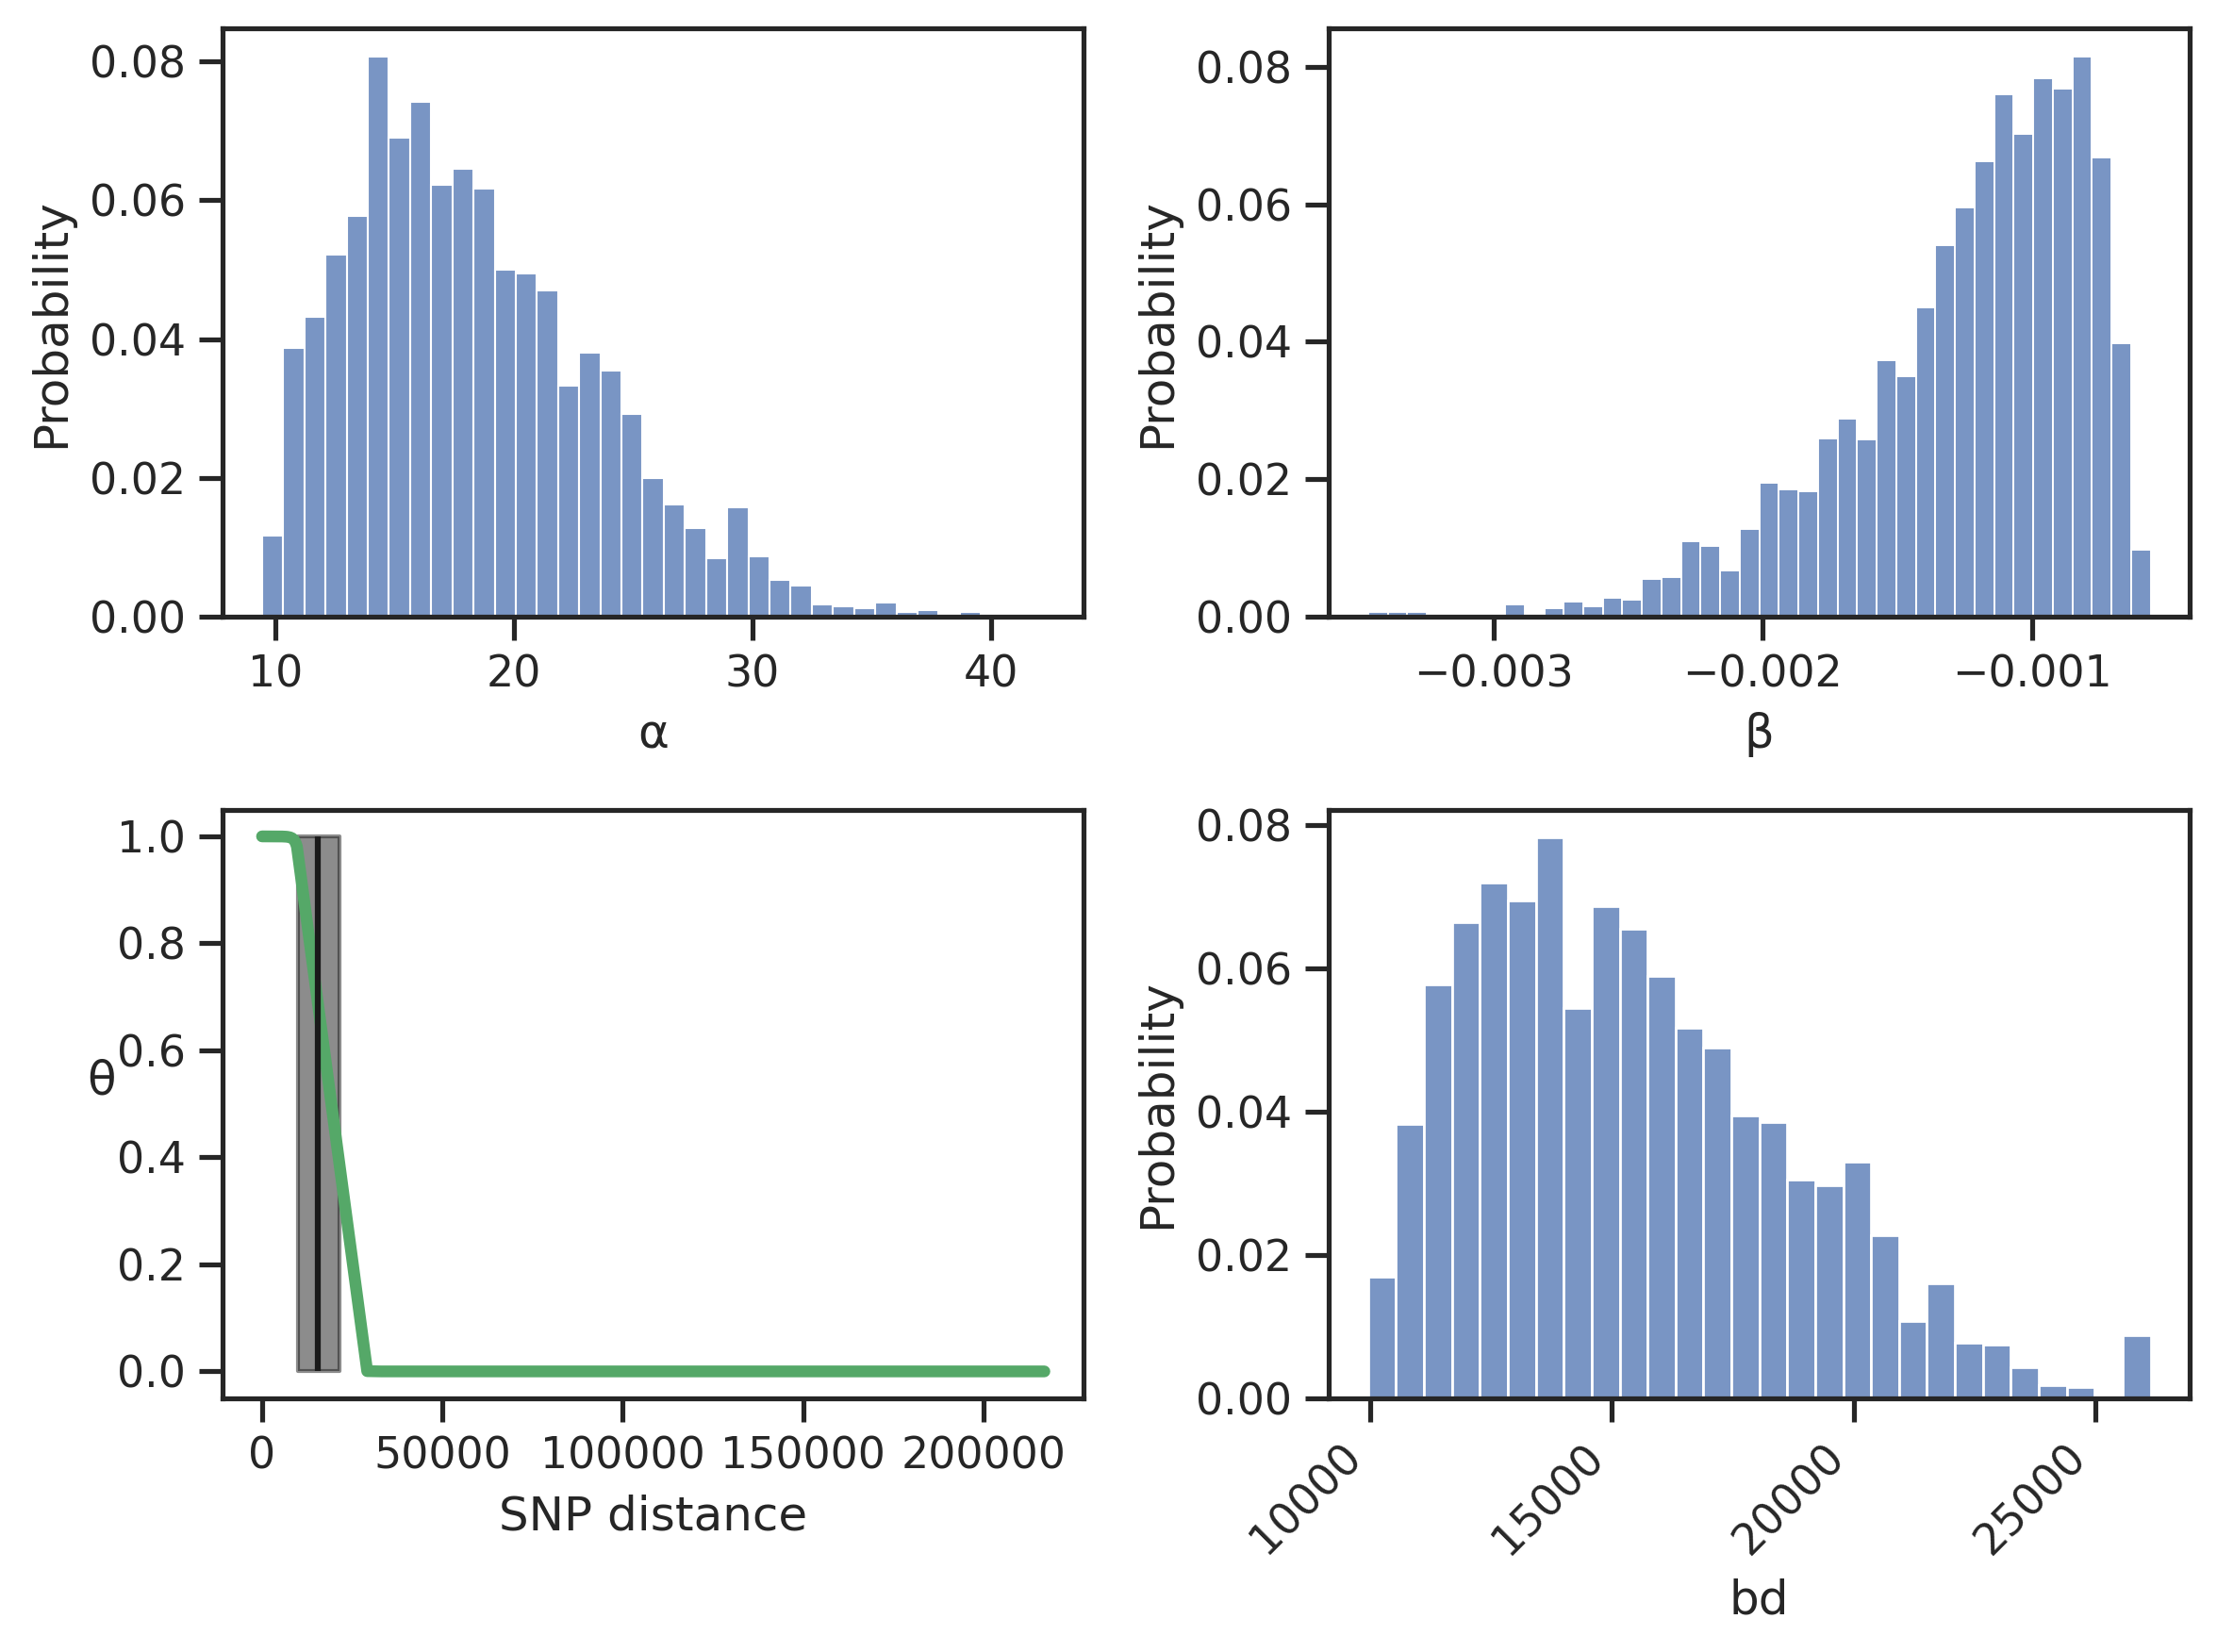

In [96]:
sns.set(font="Arial", style='ticks')
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6))

for v, ax in zip(trace_simple.varnames, axes.flatten()):
    v_mode = az.hdi(trace_simple[v].flatten(), hdi_prob=0.05).mean()
    hdi_min, hdi_max = az.hdi(trace_simple[v].flatten(), hdi_prob=0.95)
    
    if v == 'θ':
        theta = trace_simple['θ'].mean(axis=0)
        idx = np.argsort(x)
        ax.plot(x[idx], theta[idx], color='C2', lw=3)
        ax.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
        bd_hpd = az.hdi(trace_simple['bd'], hdi_prob=0.95) #az.hpd(trace_simple['bd'])
        ax.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
        ax.set_xlabel('SNP distance')
        ax.set_ylabel('θ', rotation=0)
    else:
        sns.histplot(trace_simple[v], stat='probability', ax=ax)
        ax.set_xlabel(v)
        ax.set_ylabel("Probability")
        
    print(f"{v}'s mode = {v_mode} ({hdi_min}, {hdi_max}) (shape = {trace_simple[v].shape})")

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

Get decision boundary stats

In [85]:
bd_df = learn_result_df.set_index('quarter')[['bd_mode', 'bd_hdi_min', 'bd_hdi_max']].stack().reset_index()
bd_df.columns = ['quarter', 'bd_value_type', 'bd_value']

# Plotting results across time points

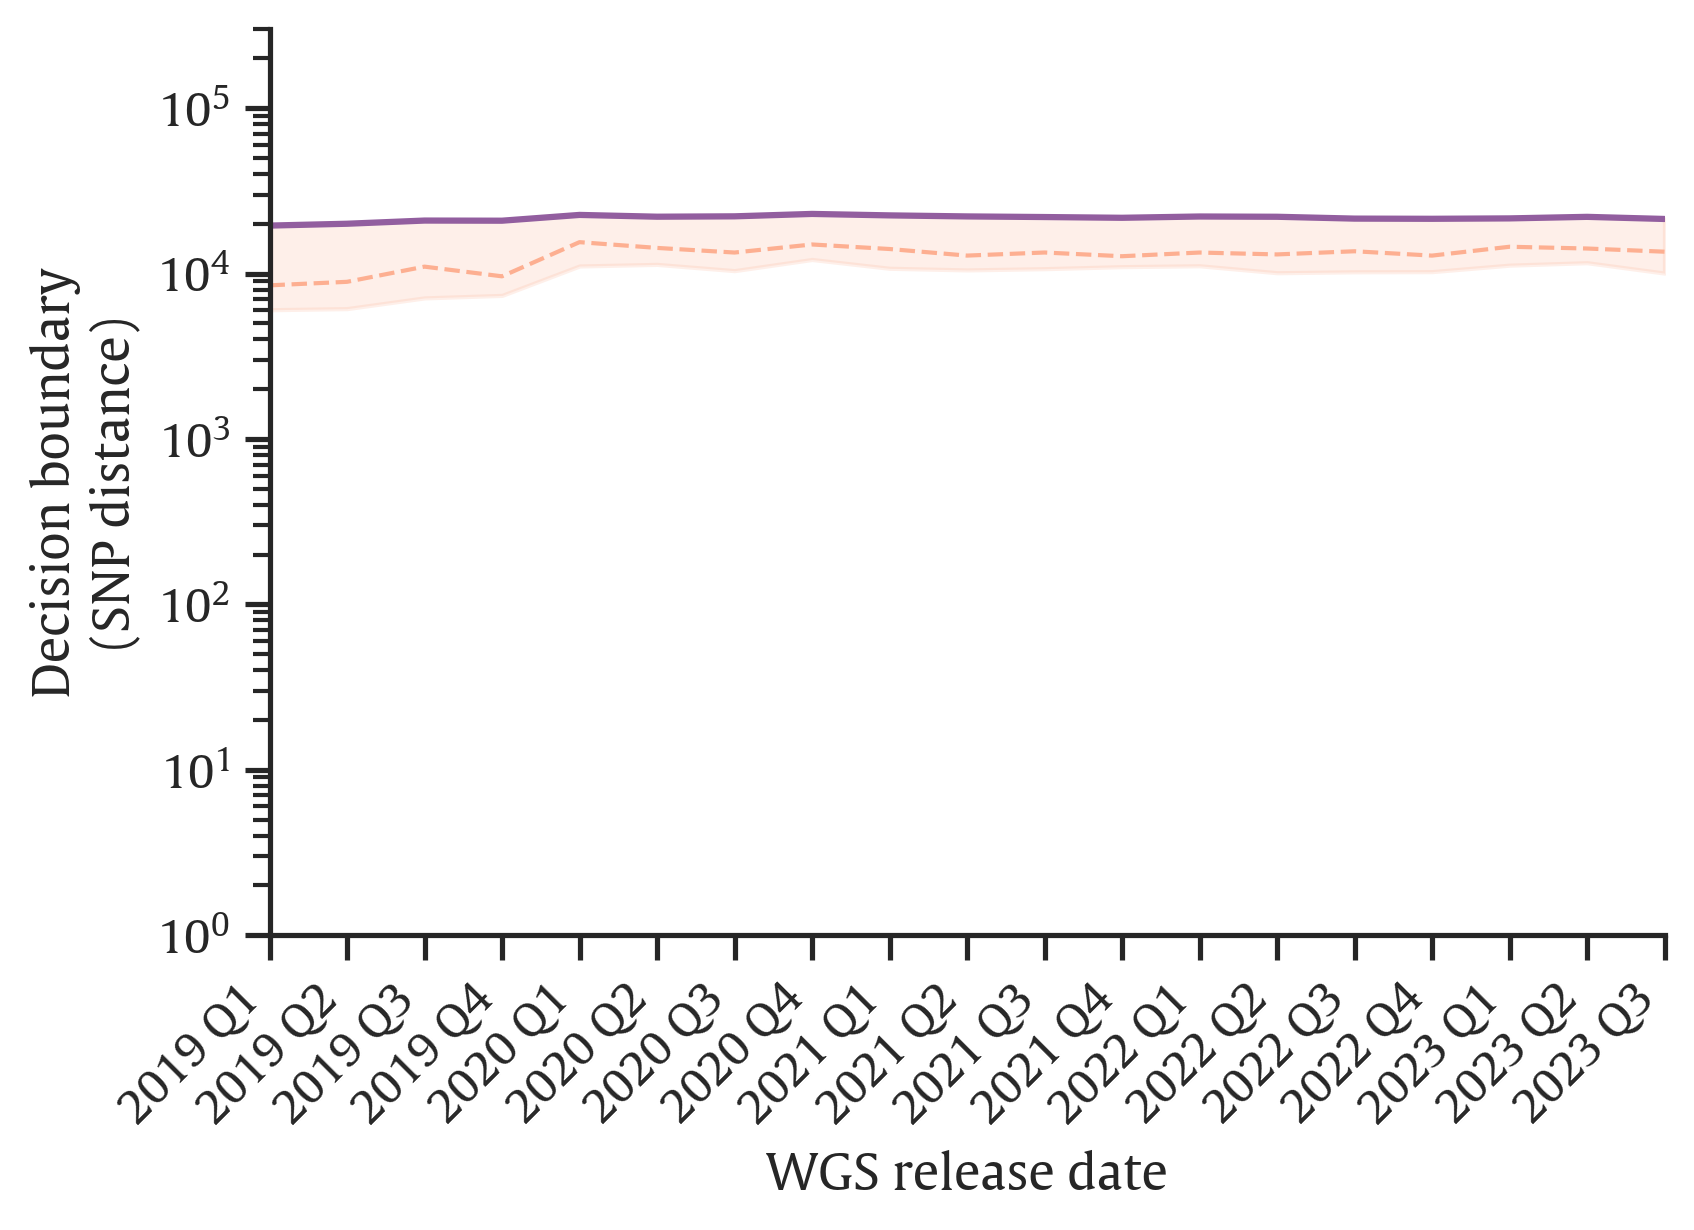

In [86]:
sns.set(font="Gulliver", style='ticks')
fig, ax = plt.subplots(figsize=(6,4))

sns.lineplot(data=bd_df[bd_df['bd_value_type']=='bd_mode'], x='quarter', y='bd_value', 
             color=lancet_cmap(5), linewidth=1, linestyle='--', ax=ax)
sns.lineplot(data=bd_df, x='quarter', y='bd_value', ci=100, linestyle='', color=lancet_cmap(5), ax=ax)
sns.lineplot(data=bd_df[bd_df['bd_value_type']=='bd_hdi_max'], x='quarter', y='bd_value', 
             color=lancet_cmap(4), ax=ax)

_ = plt.xticks(rotation=45, ha='right')
ax.set_xlabel('WGS release date')
ax.set_ylabel('Decision boundary\n(SNP distance)')
ax.set_xlim(('2019 Q1', '2023 Q3'))
ax.set_yscale('log')
ax.set_ylim((1, 300000))
sns.despine()

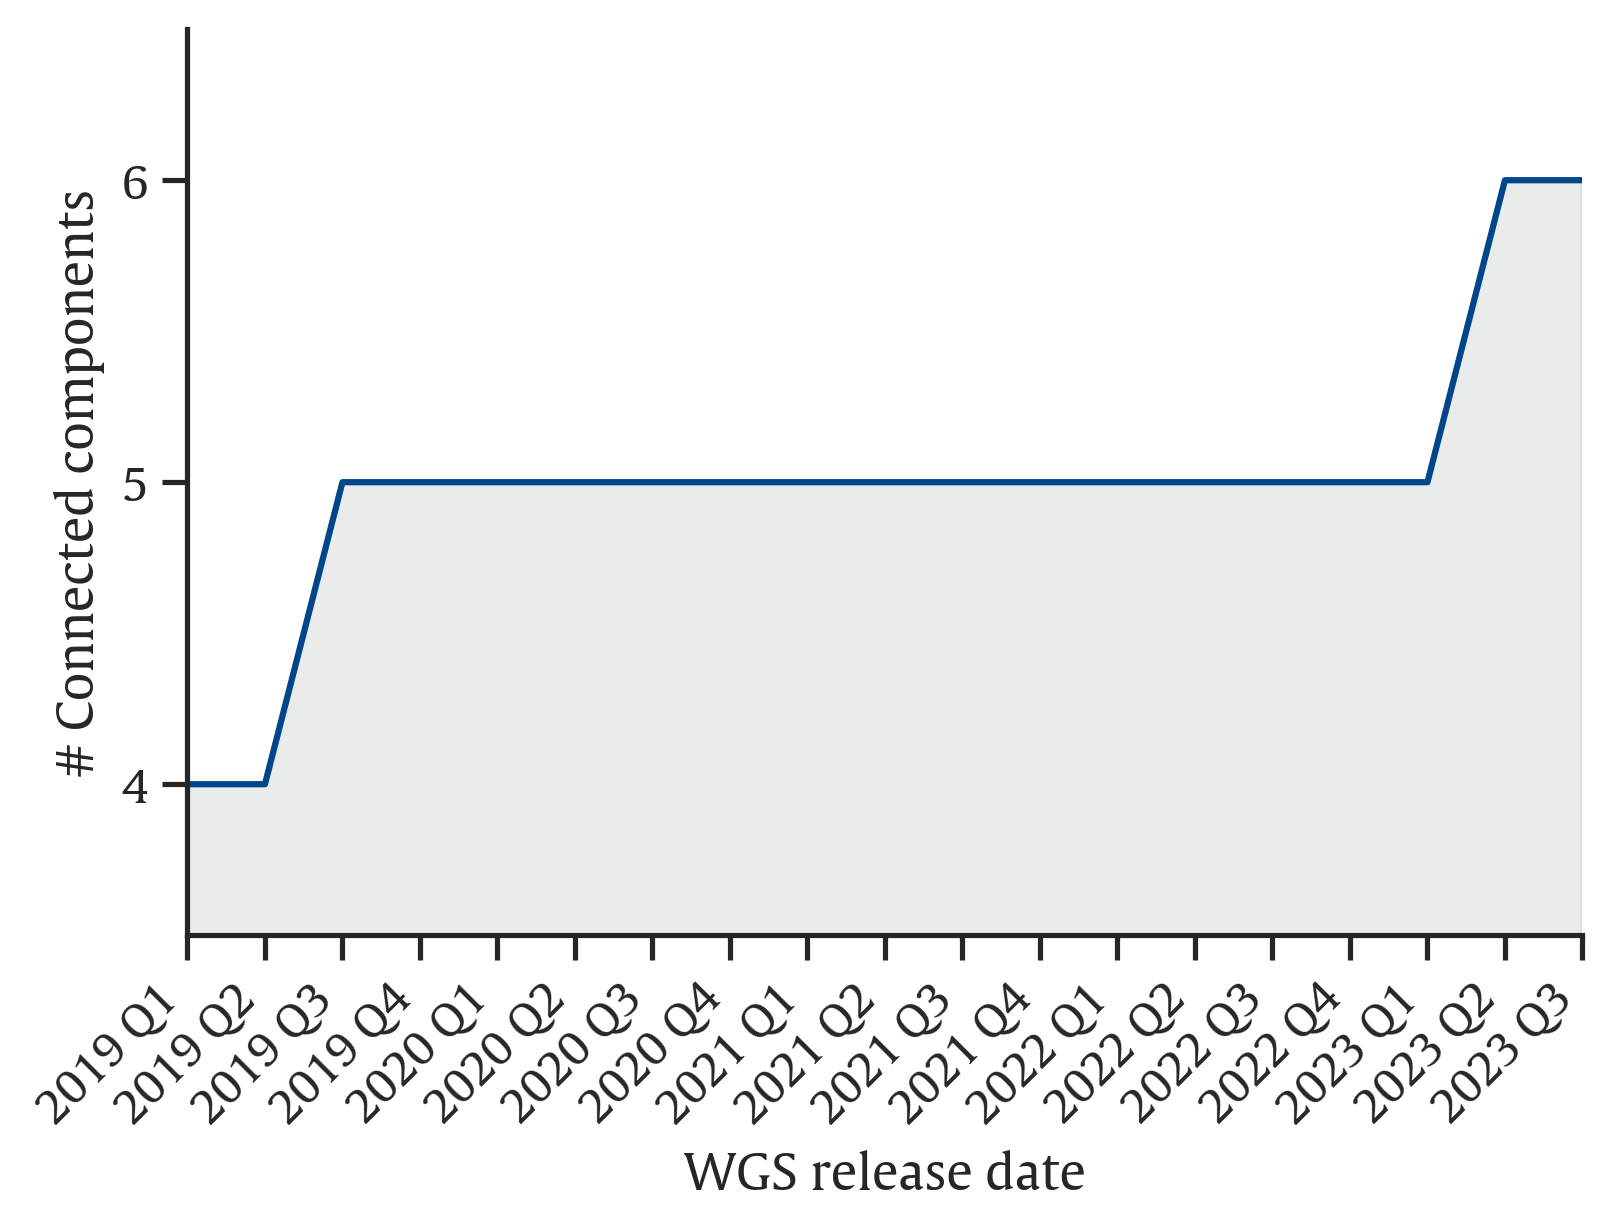

In [87]:
sns.set(font="Gulliver", style='ticks')
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=learn_result_df.drop_duplicates(), x='quarter', y='n_ccs', 
             color=lancet_cmap(0), ax=ax)

ax.fill_between(learn_result_df.drop_duplicates()['quarter'].values, 
                learn_result_df.drop_duplicates()['n_ccs'].values,
                color=lancet_light_cmap(7), alpha=0.25
               )

_ = plt.xticks(rotation=45, ha='right')
ax.set_xlabel('WGS release date')
ax.set_ylim((3.5, 6.5))
ax.set_yticks(range(4, 6+1))
ax.set_ylabel('# Connected components')
ax.set_xlim(('2019 Q1', '2023 Q3'))
sns.despine()

# Create a graph for clade detection
Only show the last time point

In [88]:
lancet_palette = sns.color_palette(["#00468BFF", '#0099B4FF', '#925E9FFF', '#FDAF91FF', '#AD002AFF', '#42B540FF', lancet_cmap(7)])

sorted_clade_name = run_date_info_df.sort_values('Clade')['Clade'].drop_duplicates().to_list()
clade_color_dict = dict(zip(sorted_clade_name, lancet_palette))
sample_clade_dict = dict(zip(run_date_info_df.index, run_date_info_df['Clade']))
sample_color_dict = {}
for k, v in sample_clade_dict.items():
    sample_color_dict[k] = clade_color_dict[v]

Subsampling nodes for visulization

In [89]:
sampled_nodes = []
k = 200
for i, c in enumerate(nx.connected_components(q_learn_graph)):
    c_graph = q_learn_graph.subgraph(c)
    print(f"c{i+1}: nodes={c_graph.number_of_nodes()} edges={c_graph.number_of_edges()}")
    if c_graph.number_of_nodes() > k:
        sampled_nodes += random.sample(c_graph.nodes, k)
    else:
        sampled_nodes += list(c_graph.nodes())

c1: nodes=26 edges=351
c2: nodes=1680 edges=1412040
c3: nodes=1590 edges=1264845
c4: nodes=4 edges=10
c5: nodes=349 edges=61066
c6: nodes=5 edges=15


In [90]:
sampled_graph = q_learn_graph.subgraph(sampled_nodes).copy()
sampled_graph.remove_edges_from(nx.selfloop_edges(sampled_graph))
sampled_graph.number_of_nodes()

635

Calculate layout and plot a graph

In [91]:
pos = nx.nx_agraph.graphviz_layout(sampled_graph, prog="neato", args='-Goverlap="False"')

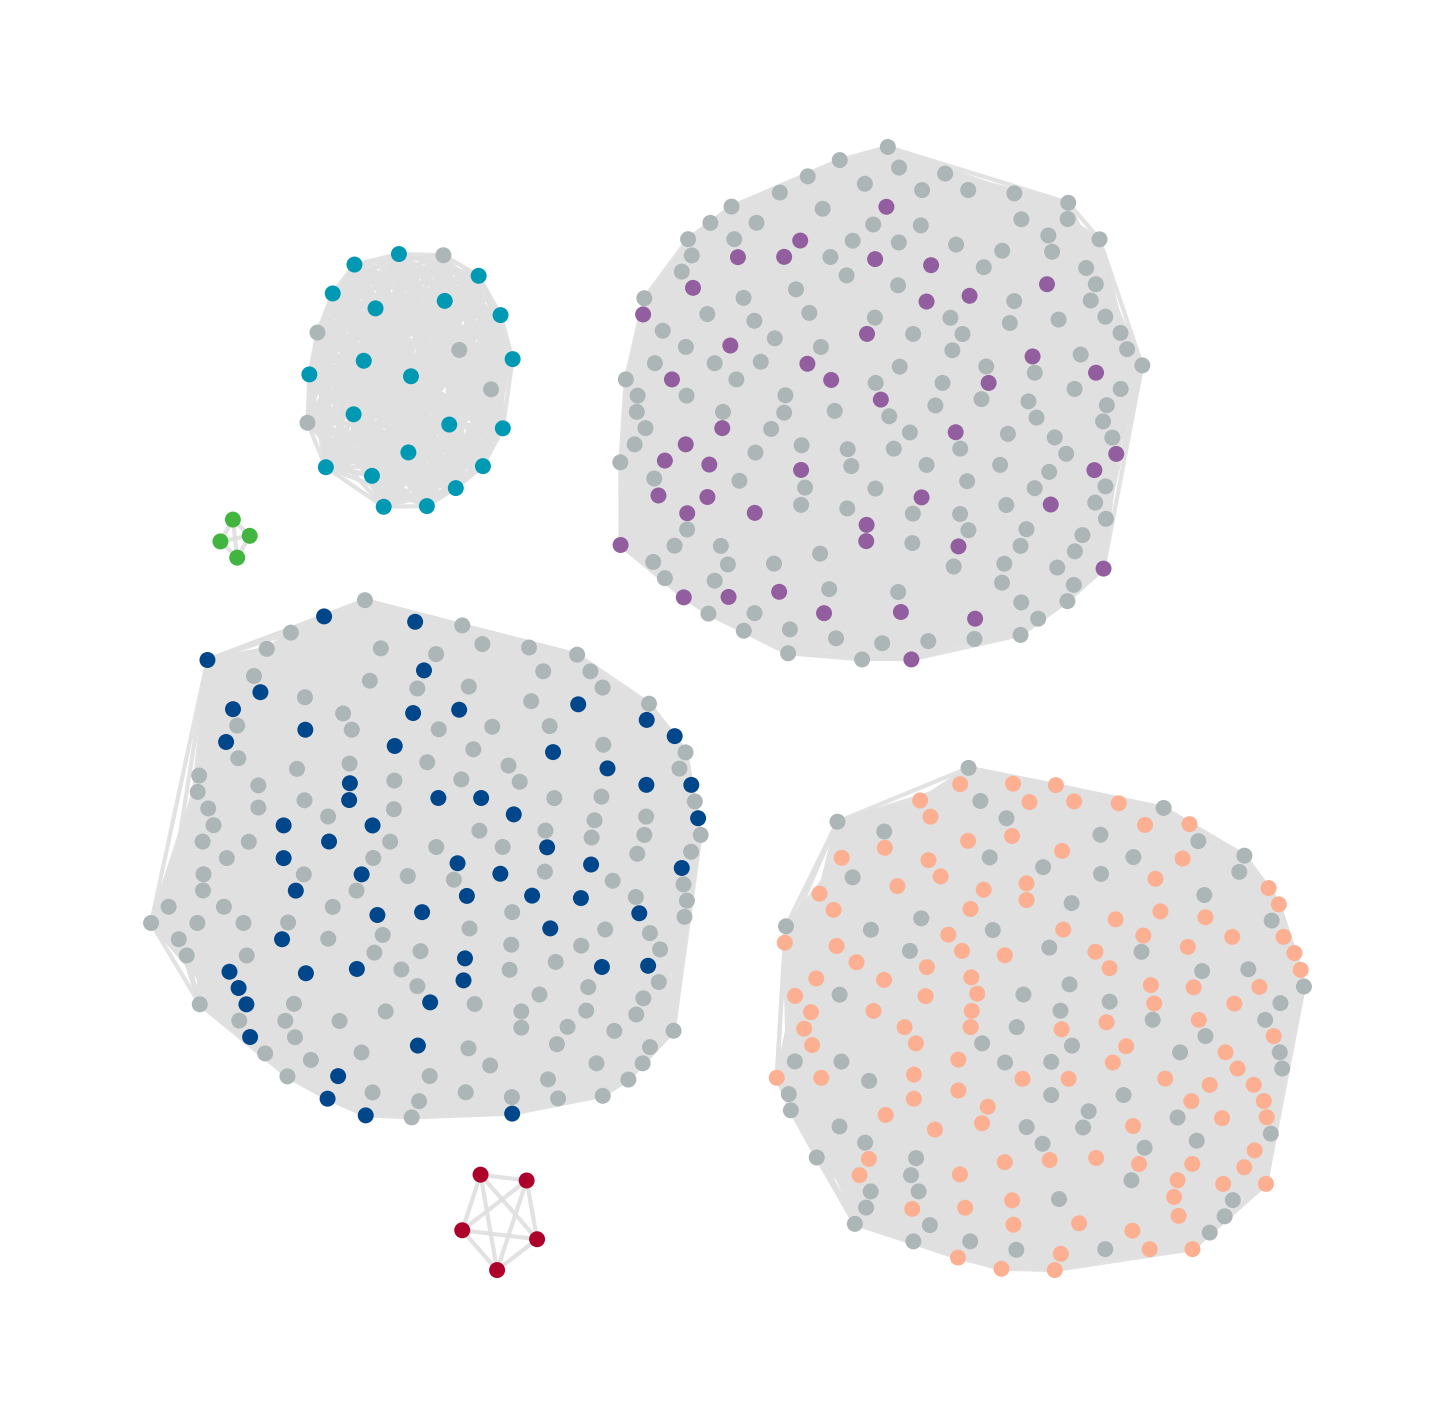

In [92]:
fig, ax = plt.subplots(figsize=(6,6))
nx.draw(sampled_graph, pos=pos, with_labels=False, node_size=8, width=1,
        node_color=[sample_color_dict[n] for n in sampled_graph.nodes()],
        edge_color="#E0E0E0EE")

ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')
plt.show()